### Manipulation of Peaks de novo results of Prochlorococus MED4 LC-MS/MS data using python.

Starting with:

    Peaks de novo results (.csv) of PTM-optimized database searches

Goal:

    Files with stripped (no PTMs) peptide lists and
    Columns with #'s of each modification in every sequence
    Column with stripped peptide lengths (# amino acids)

For technical duplicates, I exported PeaksDN search results CSVs into my ETNP 2017 git repo:

In [1]:
cd /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/

/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN


In [2]:
ls

RAL95_MED2_trypsin_1_PTMopt_DN50.csv
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped.csv
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped_peptides.txt
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped_work.ods
RAL95_MED2_trypsin_1_PTMopt_DN80_stripped_peptides.txt
RAL95_MED2_trypsin_2_PTMopt_DN50.csv
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped.csv
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped_peptides.txt
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped_work.ods
RAL95_MED2_trypsin_2_PTMopt_DN80_stripped_peptides.txt


In [16]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

In [17]:
#read the CSV into a datadrame we name 'comet' using the pandas read_csv function
peaks = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_1_PTMopt_DN50.csv")


#look at the dataframe
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,2620000.0,1245.6453,-0.6,Deamidation (NQ),98 100 99 99 99 99 99 99 100 99 99,KELN(+.98)LDTDLGK,CID
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,4180000.0,1248.6196,-0.8,NaN,98 100 100 100 99 99 99 97 98 99 99,KDLESLDSTNK,CID
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,7850000.0,813.4788,-0.3,NaN,96 98 99 100 99 99,FFLLFK,CID
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,4690000.0,1414.7166,0.2,NaN,99 100 99 99 99 96 94 99 99 99 99,KLFTDYQELMK,CID
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,43600000.0,1114.6023,-0.2,NaN,98 99 100 100 99 97 98 97 98,WALEELLNK,CID


The peptide column has the masses of modifications (e.g., 57.02 Da for carbamidomethylation of cysteine). We want to make new columns with all that information and make a column with only the 'stripped' peptide sequence that's just amino acids - this we can then align against other sequences, for example.

Modified residues were allowed for:

    fixed carbamodimethylation of cysteine 57.021464 C
    varialbe oxidation of methionine: 15.9949 M
    variable deamidation of asparagine, glumatine: 0.984016 NQ
    variable iron cation on lysine: 54.010565 K
    variable methylation of lysine and arginine: 14.015650 KR

We'll then write this manipulated dataframe to a new file.

In [24]:
# use a count function to enumerate the # of ccarbamidomethylated C's in each peptide
peaks['c-carb'] = peaks['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks['m-oxid'] = peaks['Peptide'].str.count("15.99")

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks['n-deam'] = peaks['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks['n-deam'] = peaks['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks['q-deam'] = peaks['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of iron adducted K's in each peptide
peaks['k-iron'] = peaks['Peptide'].str.count("53.92")

# use a count function to enumerate the # of methylated K's in each peptide
peaks['k-meth'] = peaks['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks['r-meth'] = peaks['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks['stripped peptide'] = peaks['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks['stripped length'] = peaks['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks['ptm-total'] = peaks['c-carb'] + peaks['m-oxid'] + peaks['n-deam'] + peaks['q-deam'] + peaks['k-iron'] + peaks['k-meth'] + peaks['r-meth']

# total the number of modifications in sequence relative to # of AAs
peaks['ptm-norm'] = peaks['ptm-total'] / peaks['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_1_PTMopt_DN50_stripped.csv")


# check out the results
peaks.head(10)

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,binned,ptm-total,ptm-norm
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,...,1,0,0,0,0,KELNLDTDLGK,11,95-100,1,0.090909
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,...,0,0,0,0,0,KDLESLDSTNK,11,95-100,0,0.000000
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,...,0,0,0,0,0,FFLLFK,6,95-100,0,0.000000
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,...,0,0,0,0,0,KLFTDYQELMK,11,95-100,0,0.000000
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,...,0,0,0,0,0,WALEELLNK,9,95-100,0,0.000000
5,3,26752,022016_RAL4_95_MED2_trypsin_1.raw,KGFVSELLDK,10,98,10,568.3217,2,41.71,...,0,0,0,0,0,KGFVSELLDK,10,95-100,0,0.000000
6,3,28983,022016_RAL4_95_MED2_trypsin_1.raw,C(+57.02)LVLFPK,7,98,7,438.7545,2,44.72,...,0,0,0,0,0,CLVLFPK,7,95-100,1,0.142857
7,3,28720,022016_RAL4_95_MED2_trypsin_1.raw,C(+57.02)LVLFPK,7,98,7,438.7538,2,44.37,...,0,0,0,0,0,CLVLFPK,7,95-100,1,0.142857
8,3,15292,022016_RAL4_95_MED2_trypsin_1.raw,KGYLLDVK,8,98,8,468.2819,2,26.13,...,0,0,0,0,0,KGYLLDVK,8,95-100,0,0.000000
9,3,32255,022016_RAL4_95_MED2_trypsin_1.raw,KAALENNALLTKK,13,98,13,707.4191,2,49.01,...,0,0,0,0,0,KAALENNALLTKK,13,95-100,0,0.000000


### Visualizing the results:

In [21]:
print("ALC max: ", peaks['ALC (%)'].max())
print("ALC min: ", peaks['ALC (%)'].min())

ALC max:  98
ALC min:  50


In [23]:
# making evenly spaced bins for the ALC data based on the min and max, called above
bins = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']

# use pandas cut function to do the binning itself
peaks['binned'] = pd.cut(peaks['ALC (%)'], bins=bins, labels=labels)


peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,c-carb,m-oxid,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,binned
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,...,0,0,1,0,0,0,0,KELNLDTDLGK,11,95-100
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,...,0,0,0,0,0,0,0,KDLESLDSTNK,11,95-100
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,...,0,0,0,0,0,0,0,FFLLFK,6,95-100
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,...,0,0,0,0,0,0,0,KLFTDYQELMK,11,95-100
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,...,0,0,0,0,0,0,0,WALEELLNK,9,95-100


        Total PTMs  Cys carb.  Met oxi.  Asp deam.  Glut deam.  Lys iron  \
50-55         2065        394       253        125          10       392   
55-60         1957        347       280        159           8       321   
60-65         1615        289       245        202           9       241   
65-70         1579        249       264        233          11       203   
70-75         1453        240       256        226          24       156   
75-80         1413        227       237        318          26       106   
80-85         1289        234       211        341          46        68   
85-90         1040        167       180        368          28        24   
90-95          621         94        77        273          34         5   
95-100          45         11         1         23           5         0   

        Lys meth.  Arg meth.  
50-55         346        545  
55-60         350        492  
60-65         267        362  
65-70         261        358  
70-75   

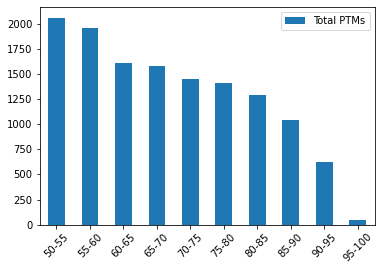

In [25]:
# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys iron': [peaks.groupby('binned')['k-iron'].sum()['50-55'], peaks.groupby('binned')['k-iron'].sum()['55-60'], peaks.groupby('binned')['k-iron'].sum()['60-65'], peaks.groupby('binned')['k-iron'].sum()['65-70'], peaks.groupby('binned')['k-iron'].sum()['70-75'], peaks.groupby('binned')['k-iron'].sum()['75-80'], peaks.groupby('binned')['k-iron'].sum()['80-85'], peaks.groupby('binned')['k-iron'].sum()['85-90'], peaks.groupby('binned')['k-iron'].sum()['90-95'], peaks.groupby('binned')['k-iron'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys iron', 'Lys meth.', 'Arg meth.'], index=index)
print (peaksbin)
plt = peaksbin.plot.bar(y='Total PTMs', rot=45)
plt

Text(0.5, 1.0, 'Arginine methylation')

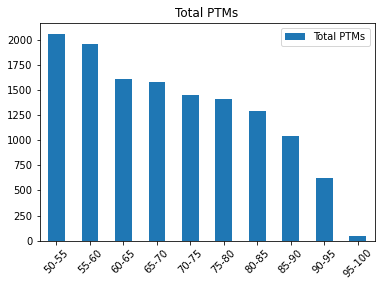

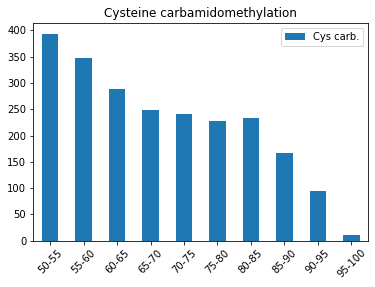

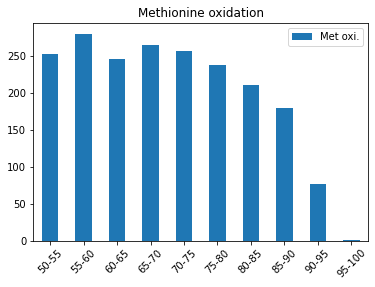

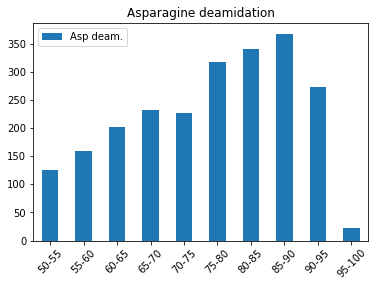

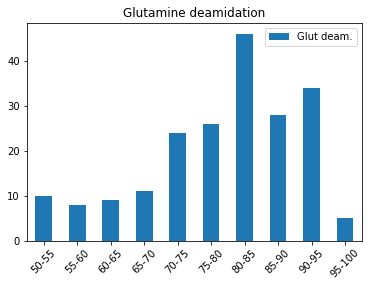

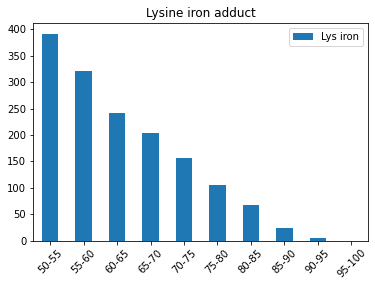

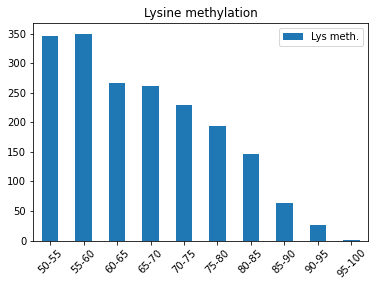

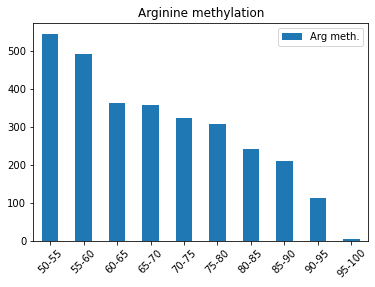

In [28]:
# bar plots of binned PTM data

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys iron': [peaks.groupby('binned')['k-iron'].sum()['50-55'], peaks.groupby('binned')['k-iron'].sum()['55-60'], peaks.groupby('binned')['k-iron'].sum()['60-65'], peaks.groupby('binned')['k-iron'].sum()['65-70'], peaks.groupby('binned')['k-iron'].sum()['70-75'], peaks.groupby('binned')['k-iron'].sum()['75-80'], peaks.groupby('binned')['k-iron'].sum()['80-85'], peaks.groupby('binned')['k-iron'].sum()['85-90'], peaks.groupby('binned')['k-iron'].sum()['90-95'], peaks.groupby('binned')['k-iron'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys iron', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = peaksbin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = peaksbin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = peaksbin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = peaksbin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = peaksbin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = peaksbin.plot.bar(y='Lys iron', rot=45)
ax6.set_title('Lysine iron adduct')

ax7 = peaksbin.plot.bar(y='Lys meth.', rot=45)
ax7.set_title('Lysine methylation')

ax7 = peaksbin.plot.bar(y='Arg meth.', rot=45)
ax7.set_title('Arginine methylation')


In [19]:
# keep only peptide column >50% ALC
pep = peaks[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_1_PTMopt_DN50_stripped_peptides.txt", header=False, index=False)


# look
pep.head()

,stripped peptide
0,KELNLDTDLGK
1,KDLESLDSTNK
2,FFLLFK
3,KLFTDYQELMK
4,WALEELLNK


In [11]:
# keep only peptides  >80% ALC
peaks80 = peaks.loc[peaks['ALC (%)'] >= 80]

# see how many rows and double check
# peaks80.head(-10)

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_1_PTMopt_DN80_stripped_peptides.txt", header=False, index=False)


# look
pep80.head()

,stripped peptide
0,KLEEALQELK
1,SKDNLLSLLK
2,KLNERETTLK
3,KSLSTLLAMEYQDK
4,FFLLFK


### Second duplicate MED2 files:

In [12]:
#read the CSV into a datadrame we name 'comet' using the pandas read_csv function
peaks = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_2_PTMopt_DN50.csv")


#look at the dataframe
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
0,4,16526,022016_RAL4_95_MED2_trypsin_2.raw,KLEEALQELK,10,98,10,600.8452,2,28.02,17100000.0,1199.6760,-0.1,NaN,98 100 100 100 98 99 98 100 99 97,KLEEALQELK,CID
1,4,29615,022016_RAL4_95_MED2_trypsin_2.raw,SKDNLLSLLK,10,98,10,565.8430,2,45.63,3250000.0,1129.6707,0.6,NaN,97 99 99 98 99 99 99 100 100 98,SKDNLLSLLK,CID
2,4,12960,022016_RAL4_95_MED2_trypsin_2.raw,KLNER(+14.02)ETTLK,10,98,10,623.3551,2,22.84,13000000.0,1244.7087,-10.5,Methylation(KR),99 100 98 99 97 99 98 99 99 98,KLNER(+14.02)ETTLK,CID
3,4,22861,022016_RAL4_95_MED2_trypsin_2.raw,KSLSTLLAMEYQDK,14,98,14,813.9160,2,36.69,2470000.0,1625.8335,-9.9,NaN,97 99 100 98 98 99 100 99 99 100 100 97 98 97,KSLSTLLAMEYQDK,CID
4,4,46354,022016_RAL4_95_MED2_trypsin_2.raw,FFLLFK,6,98,6,407.7462,2,68.10,10100000.0,813.4788,-1.1,NaN,96 98 99 100 99 99,FFLLFK,CID


In [13]:
# use a count function to enumerate the # of ccarbamidomethylated C's in each peptide
peaks['c-carb'] = peaks['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks['m-oxid'] = peaks['Peptide'].str.count("15.99")

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks['n-deam'] = peaks['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks['n-deam'] = peaks['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks['q-deam'] = peaks['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of iron adducted K's in each peptide
peaks['k-iron'] = peaks['Peptide'].str.count("53.92")

# use a count function to enumerate the # of methylated K's in each peptide
peaks['k-meth'] = peaks['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks['r-meth'] = peaks['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks['stripped peptide'] = peaks['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks['stripped length'] = peaks['stripped peptide'].apply(len)

# write modified dataframe to new txt file, same name + 'stripped'
peaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_2_PTMopt_DN50_stripped.csv")


# check out the results
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,mode,c-carb,m-oxid,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length
0,4,16526,022016_RAL4_95_MED2_trypsin_2.raw,KLEEALQELK,10,98,10,600.8452,2,28.02,...,CID,0,0,0,0,0,0,0,KLEEALQELK,10
1,4,29615,022016_RAL4_95_MED2_trypsin_2.raw,SKDNLLSLLK,10,98,10,565.8430,2,45.63,...,CID,0,0,0,0,0,0,0,SKDNLLSLLK,10
2,4,12960,022016_RAL4_95_MED2_trypsin_2.raw,KLNER(+14.02)ETTLK,10,98,10,623.3551,2,22.84,...,CID,0,0,0,0,0,0,1,KLNERETTLK,10
3,4,22861,022016_RAL4_95_MED2_trypsin_2.raw,KSLSTLLAMEYQDK,14,98,14,813.9160,2,36.69,...,CID,0,0,0,0,0,0,0,KSLSTLLAMEYQDK,14
4,4,46354,022016_RAL4_95_MED2_trypsin_2.raw,FFLLFK,6,98,6,407.7462,2,68.10,...,CID,0,0,0,0,0,0,0,FFLLFK,6


In [14]:
# keep only peptide column >50% ALC
pep50 = peaks[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_2_PTMopt_DN50_stripped_peptides.txt", header=False, index=False)


# look
pep50.head()

,stripped peptide
0,KLEEALQELK
1,SKDNLLSLLK
2,KLNERETTLK
3,KSLSTLLAMEYQDK
4,FFLLFK


In [15]:
# keep only peptides  >80% ALC
peaks80 = peaks.loc[peaks['ALC (%)'] >= 80]

# see how many rows and double check
# peaks80.head(-10)

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_2_PTMopt_DN80_stripped_peptides.txt", header=False, index=False)


# look
pep80.head()

,stripped peptide
0,KLEEALQELK
1,SKDNLLSLLK
2,KLNERETTLK
3,KSLSTLLAMEYQDK
4,FFLLFK


In [73]:
# now there are the orignial csvs, 
# the stripped peptide version of those, 
# and the txt only stripped peptides for >50 and >80% ALC
!ls /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/

RAL95_MED2_trypsin_1_PTMopt_DN50.csv
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped.csv
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped_peptides.txt
RAL95_MED2_trypsin_1_PTMopt_DN80_stripped_peptides.txt
RAL95_MED2_trypsin_2_PTMopt_DN50.csv
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped.csv
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped_peptides.txt
RAL95_MED2_trypsin_2_PTMopt_DN80_stripped_peptides.txt
